<a id="qaoa-parameter-demo"></a>

# A demo how to work with QAOA Parameter classes

This notebook illustrates the use of the various QAOA parameter classes.

## Contents

1. [Creating the problem Hamiltonian and setting up *hyperparameters*](#hyperparameters)
2. [QAOA variable parameters](#variableparams)
 - [Setting up the circuit parameters](#abstractparams)
 - [Modifying parameters](#modifyingparams)
 - [Erroneous parameter catching](#errorcatching) 
3. [Iterating over parameter ranges](#iteratingparams)

In [1]:
# import the standard modules from python
import numpy as np
import matplotlib.pyplot as plt

# import the neccesary pyquil modules
from pyquil.paulis import PauliSum, PauliTerm

# import the QAOAParameters classes and cost functions
from entropica_qaoa.qaoa.cost_function import QAOACostFunctionOnWFSim
from entropica_qaoa.qaoa.parameters import AbstractParams, ExtendedParams, StandardParams, QAOAParameterIterator

<a id="hyperparameters"></a>


## Creating the problem Hamiltonian and setting up *hyperparameters*

In general, the QAOA consists of two different types of parameters, which we will refer to as *hyperparameters* and *variable parameters*. This section covers the hyperparameters, while the section below focuses on the variable parameters. The hyperparameters are those parameters that remain fixed throughout our computation, while the variable parameters are those that we modify in seeking the optimial problem solution.

In the simplest implementation of QAOA, the hyperparameters may in turn be divided into two sets (see [Footnote 1](#footnotes) for a third example of hyperparameters):

1) Those originating from the cost Hamiltonian: 

  - the qubit register (the qubits to be used in the algorithm); 
  - the qubits with a bias term (their own $Z$ term in the Hamiltonian), and the corresponding coefficients; 
  - the qubit pairs that interact (through a $ZZ$ term in the Hamiltonian), along with the corresponding 'coupling' coefficients.

2) The number of QAOA steps we wish to perform, frequently referred to as the QAOA '$p$' parameter.

There are several ways of creating the problem Hamiltonian of interest. Ultimately, it should be in the form of a Pyquil `PauliSum` object: see __[Rigetti's documentation](http://docs.rigetti.com/en/stable/apidocs/pauli.html#)__ on the `PauliSum` and `PauliTerm` classes for more information on working with these. 

For example, let's create the simple Hamiltonian
 
\begin{equation}
H = 0.7Z_0Z_1 + 1.2Z_0Z_2 -0.5Z_0
\end{equation}

Using `PauliTerm` and `PauliSum` directly, this can be implemented as follows.

In [2]:
# create a hamiltonian on 3 qubits with 2 coupling terms and 1 bias term
Term1 = PauliTerm("Z", 0, 0.7)*PauliTerm("Z", 1)
Term2 = PauliTerm("Z", 0, 1.2)*PauliTerm("Z", 2)
Term3 = PauliTerm("Z", 0, -0.5)

hamiltonian = PauliSum([Term1,Term2,Term3])
print("hamiltonian =", hamiltonian)

hamiltonian = (0.7+0j)*Z0*Z1 + (1.2+0j)*Z0*Z2 + (-0.5+0j)*Z0


<a id="variableparams"></a>

## QAOA variable parameter classes

Having specified the problem Hamiltonian, we next move on to defining the QAOA parameters we want to use in our quantum circuit.

For a general variational quantum algorithm usch as VQE, to fully define a problem we must specify a circuit ansatz (a sequence of gates to be performed) and a corresponding parametrisation (how the parameters over which we intend to optimise are related to the sequence of gates). In QAOA, the circuit ansatz is fixed to be the alternate application of the mixer operator (also referred to as the *driver* or *reference* operator) and the cost operator (sometimes also referred to as the *phase separation* operator). The goal is then to find the parameters that optimise the cost function when evaluated with resepct to the quantum state produced by the circuit. 

We have a considerable degree of flexibility in choosing how to parametrise a QAOA problem. We can choose a smaller set of parameters, where the optimisation landscape has lower dimension at the expense of reduced expressivity. Or, we can choose a larger set, where we can generate a wider set of quantum states with lower circuit depth, but the corresponding optimisation landscape has a higher dimension. The larger the set of parameters we have to optimise over, the more difficult it can become to find the optimal solution.


The variable parameters are those we wish to optimise, which in turn depend on the specific parametrisation for the circuit we have chosen. 

- The `StandardParams` class implements the original and conventional form of the QAOA, as described in [Ref 1](#references). In time step $q$ of the algorithm, the mixer and cost Hamiltonians are applied with coefficients $\beta^{(q)}$ and $\gamma^{(q)}$, respectively, giving a total of $2p$ parameters over which we need to optimise. For example for a depth-2 ($p=2$) circuit, the unitary operator corresponding to the QAOA circuit would take the form

\begin{equation}
U(\beta_1,\beta_2,\gamma_1,\gamma_2) = \exp\left(i\beta^{(2)} H_{M}\right)\exp\left(i\gamma^{(2)} H_{C}\right)\exp\left(i\beta^{(1)} H_{M}\right)\exp\left(i\gamma^{(1)} H_{C}\right)
\end{equation}

where the mixer Hamiltonian is given by $H_M = \sum_j X_j$, and the cost Hamiltonian is given by $H_C = \sum_j h_j Z_j + (1/2)\sum_{j,k} g_{j,k} Z_jZ_k$.

- For the `ExtendedParams` class, each operator in both the cost and mixer Hamiltonians has its own angle, so that the set of variable parameters are:

    - $\mbox{betas} = \{\beta_0^{(1)},...,\beta_{n-1}^{(1)},\beta_0^{(2)},...,\beta_{n-1}^{(2)},...,\beta_0^{(p)},...,\beta_{n-1}^{(p)}\}$, where $\beta_i^{(q)}$ denotes the mixer Hamiltonian angle for qubit $i$ in the QAOA step $q$.
    - $\mbox{gammas_singles} = \left\{ \{\gamma_s^{(1)}\}, \{\gamma_s^{(2)}\},...,\{\gamma_s^{(p)}\}    \right\}$, where  where $s$ is the set of qubits with bias terms in the cost Hamiltonian, and $\{\gamma_s^{(q)}\}$ denotes the set of angles corresponding to those bias terms in QAOA step $q$.  
    - $\mbox{gammas_pairs} = \left\{ \{\Gamma_{\Pi}^{(1)}\}, \{\Gamma_{\Pi}^{(2)}\},...,\{\Gamma_{\Pi}^{(p)}\}    \right\}$, where  where $\Pi$ is the set of qubits with bias terms in the cost Hamiltonian, and $\{\Gamma_{\Pi}^{(q)}\}$ denotes the set of angles corresponding to those bias terms in QAOA step $q$.  
    
    For instance, for a depth-2 circuit the corresponding unitary operator would then become:
    
\begin{eqnarray}
U\left(\vec{\beta},\vec{\gamma},\vec{\Gamma}\right) = &&\exp\left(i\sum_{j}\beta_{j}^{(2)}X_j\right)\exp\left(i\sum_{j\in s} \gamma_{j}^{(2)}h_{j}Z_j + (i/2)\sum_{j,k \in \Pi}\Gamma_{jk}^{(2)}g_{jk}Z_jZ_k\right) \\
&\times&\exp\left(i\sum_{j}\beta_{j}^{(1)}X_j\right)\exp\left(i\sum_{j\in s} \gamma_{j}^{(1)}h_{j}Z_j + (i/2)\sum_{j,k \in \Pi}\Gamma_{jk}^{(1)}g_{jk}Z_jZ_k\right)
\end{eqnarray}
    
We currently provide two additional parameter classes that may be of interest, either for didactic or practical purposes.
    
- `AnnealingParams`: basically a digitised form of quantum annealing, with a schedule function $s(t)$; the coefficient of the mixer Hamiltonian is $(1 - s(t))$, and the coefficient of the cost Hamiltonian is $s(t)$. Unlike QAOA, therefore, the coefficients of the two Hamiltonians are necessarily related to one another.

- `FourierParams`: a heuristic parametrisation proposed by Zhou et al in reference [Ref 2](#references). The idea is that the optimal $\beta$ and $\gamma$ parameters sometimes empirically appear to be described by relatively smooth functions, meaning that one can consider working instead with the Fourier decompositions of those functions. By keeping only a fixed number of low-frequency Fourier components, the parameter space over which one must optimise can be significantly reduced.

The use of these latter two parameter classes is demonstrated in the separate notebook _AdvancedQAOAParameterDemo_.

<a id="abstractparams"></a>

### Building parameters from the `AbstractParams` class

All of the QAOA parameter classes listed above are descendants of the parent class `AbstractParams`. An object belonging to this class is characterised by the problem hyperparameters. We create such an object as follows:

In [3]:
p = 2
abstract_params = AbstractParams([hamiltonian,p])
print(abstract_params)

Hyperparameters:
	register: [0, 1, 2]
	qubits_singles: [0]
	single_qubit_coeffs: [-0.5]
	qubits_pairs: [[0, 1], [0, 2]]
	pair_qubit_coeffs: [0.7 1.2]
	n_steps: 2



Subsequently, we can initalise any of the sets of variable parameters described above by making use of the `AbstractParams` object. For example, let's set up `ExtendedParams` using the `AbstractParams` we have just defined. To do this, we call the `.from_AbstractParameters` method.

In [4]:
# Specify some angles
betas          = [[0.0, 0.1, 0.3], [0.5, 0.2, 1.2]]
gammas_singles = [[0.0], [0.5]]
gammas_pairs   = [[0.1, 0.3], [0.2, 1.2]]
parameters = (betas, gammas_singles, gammas_pairs)

extended_params = ExtendedParams.from_AbstractParameters(abstract_params,parameters)
print(extended_params)

Hyperparameters:
	register: [0, 1, 2]
	qubits_singles: [0]
	qubits_pairs: [[0, 1], [0, 2]]
Parameters:
	betas: [[0.  0.1 0.3], [0.5 0.2 1.2]]
	gammas_singles: [[0. ], [0.5]]
	gammas_pairs: [[0.1 0.3], [0.2 1.2]]



We can also create `ExtendedParams` directly, without first setting up `AbstractParams`. For the case considered above, we would simply do the following:

In [5]:
extended_direct = ExtendedParams([hamiltonian,2],parameters)
print(extended_direct)

Hyperparameters:
	register: [0, 1, 2]
	qubits_singles: [0]
	qubits_pairs: [[0, 1], [0, 2]]
Parameters:
	betas: [[0.  0.1 0.3], [0.5 0.2 1.2]]
	gammas_singles: [[0. ], [0.5]]
	gammas_pairs: [[0.1 0.3], [0.2 1.2]]



We could set up an object of any of the other parameter classes analogously to the case we have illustrated above for `ExtendedParams`, either directly, or through `AbstractParams`. The benefit of the latter method is that it allows multiple different parametrisations to be set up from the same underlying set of `hyperparameters`.

In a standard workflow, we would then pass the parameters we have initialised to a `cost_function` object, built with one of the classes `QAOACostFunctionOnQVM` or with `QAOACostFunctionOnWFSim`. To do so, we first arrange the `params` in a single 'raw' list of parameters in the form [`betas`,`gammas_singles`,`gammas_pairs`]:

In [6]:
extended_direct_raw = extended_direct.raw()
extended_direct_raw

array([0. , 0.1, 0.3, 0.5, 0.2, 1.2, 0. , 0.5, 0.1, 0.3, 0.2, 1.2])

Further examples of the use of cost function objects and optimisers are given in the _QAOAWorkflowDemo_ notebook.

### Parameters under the hood

When we printed out the parameters above, we obtained a list of the angles, and the qubits or qubit pairs to which they correspond. We can also have a look at the _internal_ `x_rotation_angles`, `z_rotation_angles` and `zz_rotation_angles`, which are automatically calculated under the hood. These are the rotation angles for the different Pauli operators in the actual execution of the quantum circuit: they are determined by products of the variable parameters (`betas`, `gammas_singles`, `gammas_pairs`) and the coefficients in the Hamiltonian itself (`single_qubit_coeffs`, `pair_qubit_coeffs`).

In [7]:
print("\n x_rotation_angles:\n", extended_direct.x_rotation_angles)
print("\n z_rotation_angles:\n", extended_direct.z_rotation_angles)
print("\n zz_rotation_angles:\n", extended_direct.zz_rotation_angles)


 x_rotation_angles:
 [[0.  0.1 0.3]
 [0.5 0.2 1.2]]

 z_rotation_angles:
 [[-0.  ]
 [-0.25]]

 zz_rotation_angles:
 [[0.07 0.36]
 [0.14 1.44]]


### "Linear ramp from Hamiltonian" parametrisation

For all parameter classes, we also provide the `.linear_ramp_from_hamiltonian()` method. This automatically determines a set of `betas`, `gammas_singles`, and `gammas_pairs` by analogy to a quantum annealing schedule, as we now explain.

As usual, we specify the desired number of circuit iterations $p$ we wish to perform. If we were to view this QAOA circuit as a discretised quantum annealing procedure over a total time $T$, we would need to specify $p$ values for the annealing schedule function $s(t)$ - one for each timestep. See the notebook _AdvancedQAOAParameterDemo_ for a more detailed explanation of quantum annealing, and the meaning of the function $s(t)$.

If we choose the annealing schedule $s(t)$ to be a linear function of $t$, then the `betas` will linearly decrease from 0 to $T$, while the `gammas_singles` and `gammas_pairs` (which, in annealing, are not distinguished as separate parameters) will linearly increase. The `.linear_ramp_from_hamiltonian()` method simply assumes that we are performing a discretised form of quantum annealing, with a linear schedule function $s(t) \propto t$, with the slope dependent on the number of steps $p$.

Let's look at a specific example with the `StandardParams` class. For reference, we reproduce the corresponding code snippet from `qaoa.parameters.py` here.

```python
# create evenly spaced n_steps at the centers of n_steps intervals
dt = time / n_steps
times = np.linspace(time * (0.5 / n_steps), time * (1 - 0.5 / n_steps), n_steps)

# fill betas, gammas_singles and gammas_pairs
betas = np.array([dt * (1 - t / time) for t in times])
gammas_singles = np.array([dt * t / time for t in times])
gammas_pairs = np.array([dt * t / time for t in times])
```

Let's set up parameters for the case `n_steps` (i.e. $p$) = 2, with the Hamiltonian from above.

In [8]:
p = 2   
T = 1 # total time T of the annealing schedule
params = StandardParams.linear_ramp_from_hamiltonian(hamiltonian, n_steps=p, time=T) 
print(params)

Hyperparameters:
	register: [0, 1, 2]
	qubits_singles: [0]
	qubits_pairs: [[0, 1], [0, 2]]
Parameters:
	betas: [0.375 0.125]
	gammas: [0.125 0.375]



As expected for `StandardParams`, we get one value for each of `betas` and `gammas` for each timestep up to our specified value of $p$. The timestep length (the duration of each pulse in the circuit) is $dt = 0.5$, and the times at which we apply them are `times` = 0.25 and 0.75 here.

In the annealing Hamiltonian, in our convention the coefficient of the mixer Hamiltonian is $(1 - s(t))$, hence the angles `beta` we obtain here are $[0.5\times (1 - 0.25), 0.5\times (1 - 0.75)] = [0.375, 0.125]$. In a similar way, we obtain `gammas` $= [0.125, 0.375]$ from the fact that the coefficient of the cost Hamiltonian in the annealing process is $s(t)$.

In the case of the `ExtendedParams` class, we follow a similar logic, however in computing the `gammas_singles` and `gammas_pairs`, we also take account of the individual Hamiltonian coefficients - i.e. the `single_qubit_coeffs` and `pair_qubit_coeffs` - in determining the angles.

In this example, we explicitly passed in a total annealing time $T$ as an argument to the method. As an important point, if the total annealing time is very large compared to the number of steps $p$, then the QAOA will not perform well, since it would deviate far from the very notion of an adiabatic path between the ground states of the mixer and cost Hamiltonians. Likewise, a short total annealing time would correspond to a rapidly executed schedule, which is also likely to perform poorly.

If the user does not pass a value for `time` to the `.linear_ramp_from_hamiltonian` method, a value is determined automatically from the number of steps $p$ specified. Empirically, we have found that a value $T = 0.7\times p$ appears to strike a reasonable balance between the two extremes described above, and this is therefore the value we have chosen to implement.

<a id="modifyingparams"></a>

## Modifying parameters

We may wish to modify the parameters that have been set up, before running QAOA with them. The two ways we can do this are to modify the `params` or the `raw_params`.

In [9]:
# Current params and under-the-hood equivalents
print(params)
print("\n x_rotation_angles:\n", params.x_rotation_angles)
print("\n z_rotation_angles:\n", params.z_rotation_angles)
print("\n zz_rotation_angles:\n", params.zz_rotation_angles)

Hyperparameters:
	register: [0, 1, 2]
	qubits_singles: [0]
	qubits_pairs: [[0, 1], [0, 2]]
Parameters:
	betas: [0.375 0.125]
	gammas: [0.125 0.375]


 x_rotation_angles:
 [[0.375 0.375 0.375]
 [0.125 0.125 0.125]]

 z_rotation_angles:
 [[-0.0625]
 [-0.1875]]

 zz_rotation_angles:
 [[0.0875 0.15  ]
 [0.2625 0.45  ]]


Let's modify the first `betas` parameter:

In [10]:
params.betas[0] = np.pi
print(params)
print("\n x_rotation_angles:\n", params.x_rotation_angles)
print("\n z_rotation_angles:\n", params.z_rotation_angles)
print("\n zz_rotation_angles:\n", params.zz_rotation_angles)

Hyperparameters:
	register: [0, 1, 2]
	qubits_singles: [0]
	qubits_pairs: [[0, 1], [0, 2]]
Parameters:
	betas: [3.14159265 0.125     ]
	gammas: [0.125 0.375]


 x_rotation_angles:
 [[3.14159265 3.14159265 3.14159265]
 [0.125      0.125      0.125     ]]

 z_rotation_angles:
 [[-0.0625]
 [-0.1875]]

 zz_rotation_angles:
 [[0.0875 0.15  ]
 [0.2625 0.45  ]]


If we know the index of the parameter(s) we wish to vary in the `raw` list, we can also modify them there.

<a id="errorcatching"></a>

## Erroneous parameter catching

If the user accidentally enters a set of variable parameters that are inconsistent with the problem hyperparameters, the error is either automatically corrected, or flagged as an error for further investigation. For example, suppose we use `ExtendedParams` for a 3-qubit problem with $p=2$ timesteps. The shape of the `betas` array we input should be $2\times 3$, but what happens if we instead pass in an array of shape $1\times 6$?

In [11]:
betas = np.random.rand(6) # Wrong shape, should be 2x3
gammas_singles = [0.5, 0.5] # Correct shape
gammas_pairs = [[0.5, 0.9, 0.4, 0.2]] # Wrong shape, should be 2x2

parameters = (betas, gammas_singles, gammas_pairs)

extended_params_error = ExtendedParams([hamiltonian,2],parameters)
print(extended_params_error)

Hyperparameters:
	register: [0, 1, 2]
	qubits_singles: [0]
	qubits_pairs: [[0, 1], [0, 2]]
Parameters:
	betas: [[0.81354931 0.92451047 0.12981203], [0.47000901 0.72644754 0.55071168]]
	gammas_singles: [[0.5], [0.5]]
	gammas_pairs: [[0.5 0.9], [0.4 0.2]]



The parameters have been reshaped into arrays of the correct dimensions, consistent with the hyperparameters. If, however, we pass in an array whose incorrect shape is likely to result from a more systematic error, this is flagged to the user. 

For example, if we try to run the following code

    betas = np.random.rand(6) # Wrong shape, should be 2x3
    gammas_singles = [0.5, 0.5] # Correct shape
    gammas_pairs = [[0.5], [0.9, 0.4, 0.2]] # Likely to be a more systematic error on the user's part
    parameters = (betas, gammas_singles, gammas_pairs)
    extended_params_error = ExtendedParams([hamiltonian,2],parameters)
    
we obtain the error message `ValueError: gammas_pairs must have shape (2, 2)`.

<a id="iteratingparams"></a>

## Iterating over parameter ranges

We may sometimes want to investigate what happens if we vary one of the parameters over some specfied range, keeping all others fixed. The `QAOAParameterIterator` class gives a convenient way of doing this.

For the parameters above, we could for example take one of the `gammas` to iterate over. Suppose we take the second one, `gammas[1]`, and we want to vary it in steps of size 1/3 between 0 and 1:

In [12]:
the_range = np.arange(0, 1, 0.3334)
the_parameter = "gammas[1]"
iterator= QAOAParameterIterator(params, the_parameter, the_range)
for i,p in zip(range(len(the_range)),iterator):
    print('Parameters at step' + str(i) + ':')
    print(p)

Parameters at step0:
Hyperparameters:
	register: [0, 1, 2]
	qubits_singles: [0]
	qubits_pairs: [[0, 1], [0, 2]]
Parameters:
	betas: [3.14159265 0.125     ]
	gammas: [0.125 0.   ]

Parameters at step1:
Hyperparameters:
	register: [0, 1, 2]
	qubits_singles: [0]
	qubits_pairs: [[0, 1], [0, 2]]
Parameters:
	betas: [3.14159265 0.125     ]
	gammas: [0.125  0.3334]

Parameters at step2:
Hyperparameters:
	register: [0, 1, 2]
	qubits_singles: [0]
	qubits_pairs: [[0, 1], [0, 2]]
Parameters:
	betas: [3.14159265 0.125     ]
	gammas: [0.125  0.6668]



As expected, in the loop all parameters stay constant except for `gammas[1]` which went up in steps of thirds. 

Of course, we can also nest these iterators to sweep two-dimensional paramter landscapes. For instance, suppose we now sweep over parameter ranges for both `gammas[1]` and `betas[0]`:

In [13]:
range1 = np.arange(0,1,0.5)
range2 = np.arange(2,3,0.5)
iterator1 = QAOAParameterIterator(params, "gammas[1]", range1)
for j in iterator1:
    for p in QAOAParameterIterator(j, "betas[0]", range2):
        print("betas =", p.betas, ",", "gammas =", p.gammas)

betas = [2.    0.125] , gammas = [0.125 0.   ]
betas = [2.5   0.125] , gammas = [0.125 0.   ]
betas = [2.    0.125] , gammas = [0.125 0.5  ]
betas = [2.5   0.125] , gammas = [0.125 0.5  ]


We can nest iterators arbitrarily, which allows for parameter sweeps and subsequent landscape analysis of any desired set of parameters. This functionality will be demoed in a separate notebook.

In [14]:
# Sweep over three parameters

iterator1 = QAOAParameterIterator(params,"betas[0]",np.arange(0,1,0.5))
for p1 in iterator1:
    iterator2 = QAOAParameterIterator(p1,"betas[1]",np.arange(0,1,0.5))
    for p2 in iterator2:
        iterator3 = QAOAParameterIterator(p2,"gammas[0]",np.arange(0,1,0.5))
        for j in iterator3:
            print("betas =", j.betas, ",", "gammas =", j.gammas)

betas = [0. 0.] , gammas = [0.  0.5]
betas = [0. 0.] , gammas = [0.5 0.5]
betas = [0.  0.5] , gammas = [0.  0.5]
betas = [0.  0.5] , gammas = [0.5 0.5]
betas = [0.5 0. ] , gammas = [0.  0.5]
betas = [0.5 0. ] , gammas = [0.5 0.5]
betas = [0.5 0.5] , gammas = [0.  0.5]
betas = [0.5 0.5] , gammas = [0.5 0.5]


<a id="landscape_sweeps"></a>

This is copied from UtilitiesDemo and should be merged with the previous section

## Landscape sweeps 
This section shows how to use the `QAOAParameterIterator` class, which allows one to compute the cost function value of parametric wavefunctions produced by QAOA circuits, where one or two parameters of interest are varied, and all others are kept fixed. Let's work again with a simple 2-qubit problem, in the `ExtendedParams` class, with $p=3$ timesteps.

In [15]:
h_test = []
h_test.append(PauliTerm("Z", 0, 0.7)*PauliTerm("Z", 1))
h_test.append(PauliTerm("Z", 0, -0.5))
h_test = PauliSum(h_test)

We require 3x2 `betas` parameters, 3x1 `gammas_singles` and 3x1 `gammas_pairs` parameters, which we will initialise randomly:

In [16]:
betas = np.random.rand(3,2)
gammas_singles = np.random.rand(3,1)
gammas_pairs = np.random.rand(3,1)
parameters = (betas,gammas_singles,gammas_pairs)

In [17]:
extendedparams = ExtendedParams([h_test,3],parameters)
print(extendedparams)

Hyperparameters:
	register: [0, 1]
	qubits_singles: [0]
	qubits_pairs: [[0, 1]]
Parameters:
	betas: [[0.65056532 0.57383267], [0.24392659 0.12674536], [0.92882992 0.63008667]]
	gammas_singles: [[0.35282579], [0.04703811], [0.27452767]]
	gammas_pairs: [[0.68789131], [0.52202787], [0.59139144]]



We have a total of 12 parameters; as an example, let's focus on how the cost function value changes when we vary the `beta` angle on the second qubit in the second QAOA step (p=2). This is the `[1][1]` in the `betas` list. We will vary its range from 0 to $2\pi$.

In [18]:
range_ = np.linspace(0,2*np.pi,100)
param_ = "betas[1][1]"
iterator = QAOAParameterIterator(extendedparams, param_, range_)

We now want to compute the cost function value with all the different values of the specified parameter of interest.

In [19]:
cost_vals = np.zeros((len(range_,)))
dev_vals = np.zeros((len(range_,)))
ind = 0
for i,p in zip(range(len(range_)),iterator):
    
    cost_function = QAOACostFunctionOnWFSim(h_test,
                                            params=p,
                                            scalar_cost_function=False)
    
    
    val,dev = cost_function(p.raw(), nshots=1000)
    cost_vals[i] = val
    dev_vals[i] = dev

Below we plot the energy landscape as a function of the parameter of interest in the specified range, together with the standard deviation. A more thorough set of methods for visualising energy landscapes will be demonstrated in a separate notebook.

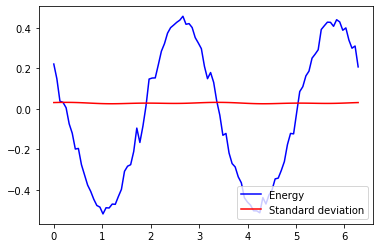

In [20]:
plt.plot(range_,cost_vals,'b',range_,dev_vals,'r')
plt.legend(('Energy', 'Standard deviation'),
           loc='lower right');

<a id='footnotes'></a>

## Footnotes

1. There are other hyperparameters that we will not consider in this notebook. For example, here we have assumed that the mixer Hamiltonian is simply the sum of Pauli X operators on all qubits. However, one could clearly consider other types of mixers - see for example [Ref 3](#references). 

<a id='references'></a>

## References

1. E. Farhi et al, __[*A Quantum Approximate Optimization Algorithm*](https://arxiv.org/abs/1411.4028)__

2. L. Zhou et al, __[*Quantum Approximate Optimization Algorithm: Performance, Mechanism, and Implementation on Near-Term Devices*](https://arxiv.org/abs/1812.01041)__

3. Z. Wang et al, __[*XY-mixers: analytical and numerical results for QAOA*](https://arxiv.org/pdf/1904.09314.pdf)__